在布朗运动中，我们得到几何布朗运动与伊藤公式:
$$
dS = \mu S dt + \sigma S dz \\ 
dG = (\frac{\partial G}{\partial t} + \frac{\partial G}{\partial S} \mu S + \frac{1}{2} \frac{\partial^2 G}{\partial S^2} \sigma^2 S^2) dt + \frac{\partial G}{\partial S} \sigma S dz \tag{2.1}
$$

利用BSM偏微分方程：
$$
\frac{\partial f}{\partial t} + \frac{\partial f}{\partial S} r S + \frac{1}{2} \frac{\partial^2 f}{\partial S^2} \sigma^2 S^2 = rf \tag{2.2}
$$

可得BSM定价公式：
$$
C = S_0 * N(d_1) - K * e^{-rT} * N(d_2)\\
P = K * e^{-rT} * N(-d_2) - S_0 * N(-d_1)\\
d_1 = \frac{1}{\sigma \sqrt{T}} (\ln(S_0/K) + (r + 0.5 \sigma^2) T)\\
d_2 = d_1 - \sigma \sqrt{T}
\tag{2.3}
$$

In [ ]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

def BSM_cal(CP,S,X,sigma,T,r,b):
    '''
    Parameters
    ----------
    CP : str
        'C' for call option, 'P' for put option
    S : float
        spot price of the underlying asset
    X : float
        strike price of the option
    sigma : float
        volatility of the underlying asset
    T : float
        time to maturity of the option
    r : float
        risk-free interest rate
    b : float
        cost of carry
        持有成本，当b = r 时，为标准的无股利模型，b=0时，为期货期权，b为r-q时，为支付股利模型，b为r-rf时为外汇期权.
    Returns
    -------
    float
        fair price of the Euro option
    '''
    d1 = (np.log(S/X) + (b + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    print(d1)
    if CP == 'C':
        price = S*np.exp((b-r)*T)*stats.norm.cdf(d1) - X*np.exp(-r*T)*stats.norm.cdf(d2)
    elif CP == 'P':
        price = X*np.exp(-r*T)*stats.norm.cdf(-d2) - S*np.exp((b-r)*T)*stats.norm.cdf(-d1)
    else:
        raise ValueError("CP must be 'C' or 'P'")
    return price


In [ ]:

class BSM:
    def __init__(self,CP,S,X,sigma,T,r,b):
        self.CP = CP
        self.S = S
        self.X = X
        self.T = T
        self.r = r
        self.b = b
        self.sigma = sigma

        self.d1 = None
        self.d2 = None
        self.price = self.BSM_Euro_cal(self.CP,self.S,self.X,self.sigma,self.T,self.r,self.b)

        #作图
        #敏感性分析
        self.S_array = self.S
        self.X_array = self.X
        self.T_array = self.T
        self.r_array = self.r
        self.b_array = self.b
        self.sigma_array = self.sigma

        self.V_array_C = None
        self.V_array_P = None

    
    def BSM_Euro_cal(self,CP,S,X,sigma,T,r,b):
        '''
        Parameters
        ----------
        CP : str
            'C' for call option, 'P' for put option
        S : float
            spot price of the underlying asset
        X : float
            strike price of the option
        sigma : float
            volatility of the underlying asset
        T : float
            time to maturity of the option
        r : float
            risk-free interest rate
        b : float
            cost of carry
            持有成本，当b = r 时，为标准的无股利模型，b=0时，为期货期权，b为r-q时，为支付股利模型，b为r-rf时为外汇期权.
        Returns
        -------
        float
            fair price of the Euro option
        '''

        self.d1 = (np.log(S/X) + (b + sigma**2/2)*T) / (sigma*np.sqrt(T))
        self.d2 = self.d1 - sigma*np.sqrt(T)
        if CP == 'C':
            price = S*np.exp((b-r)*T)*stats.norm.cdf(self.d1) - X*np.exp(-r*T)*stats.norm.cdf(self.d2)
        elif CP == 'P':
            price = X*np.exp(-r*T)*stats.norm.cdf(-self.d2) - S*np.exp((b-r)*T)*stats.norm.cdf(-self.d1)
        else:
            raise ValueError("CP must be 'C' or 'P'")
        return price
    
    def plot_sensitivity(self,x_array,array_name):
        import matplotlib.pyplot as plt
        plt.rcParams['font.sans-serif'] = ['SimHei']
        plt.rcParams['axes.unicode_minus'] = False
        if array_name == "S":
            self.S_array = x_array
        elif array_name == "X":
            self.X_array = x_array
        elif array_name == "T":
            self.T_array = x_array
        elif array_name == "r":
            self.r_array = x_array
        elif array_name == "b":
            self.b_array = x_array
        elif array_name == "sigma":
            self.sigma_array = x_array
        else:
            raise ValueError("array_name must be 'S','X','T','r','b','sigma'")

        self.V_array_C = self.BSM_Euro_cal(CP = "C",S = self.S_array,X = self.X_array,sigma = self.sigma_array,T = self.T_array,r = self.r_array,b = self.b_array)
        self.V_array_P = self.BSM_Euro_cal(CP = "P",S = self.S_array,X = self.X_array,sigma = self.sigma_array,T = self.T_array,r = self.r_array,b = self.b_array)
        plt.plot(x_array,self.V_array_C,label="看涨期权")
        plt.plot(x_array,self.V_array_P,label="看跌期权")
        plt.xlabel(array_name)
        plt.ylabel("期权价值")
        plt.legend()

        self.S_array = self.S
        self.X_array = self.X
        self.T_array = self.T
        self.r_array = self.r
        self.b_array = self.b
        self.sigma_array = self.sigma

        return

    def binary(self,C0,CP,S,X,T,r,b,vol_est= 0.2):
        '''
        求隐含波动率
        '''
        pass



    

    

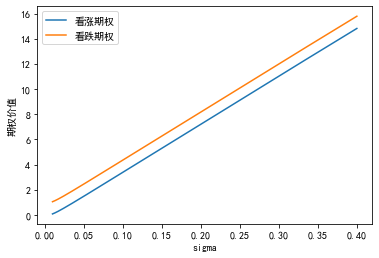

In [52]:
a = BSM(CP = "C",S = 99,X = 100,sigma = 0.2,T = 1,r = 0.03,b = 0)
a.plot_sensitivity(x_array = np.linspace(0.01,0.40,1000),array_name = "sigma")